In [1]:
import sys
sys.path.append('../')

import numpy as np
from numpy.typing import NDArray
import scipy
from dataclasses import dataclass
from typing import Callable
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import mpmath
import dill
import pickle
import os
import multiprocess as mp

from ray_delay.ray_detector import RayDetectorSpec, RayImpactSimulator
from stim_surface_code import patch, memory
from ray_delay.factory_simulator import Redundant15To1
from ray_delay.noise_model_patch import NoiseModelPatch
from ray_delay.noise_model import RayModelType, CosmicRayParams

import qc_utils.stats
import qc_utils.plot

mpmath.mp.dps = 50

Python(76530) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [2]:
dx = 7
dz = 3
dm = 3

f = Redundant15To1(dx, dz, dm, cache_cycles_per_distillation=True, mapping_mode='remap')
buffer_patch = memory.MemoryPatch(dx, dx, dm)
buffer_patch_nqubits = len(buffer_patch.all_qubits)
factory = Redundant15To1(7, 3, 3)
factory_nqubits = factory.num_phys_qubits

In [3]:
def expected_remap_cycle_overhead(ray_rate, recovery_time, online_chance, online_overhead):
    """Calculate the expected qubitcycle overhead for a given ray rate, recovery
    time, online chance, and online overhead. Assumes that more than one ray
    impact will always result in the factory being offline.
    
    Args:
        ray_rate: The rate of rays in rays/qubit/s.
        recovery_time: The time it takes to recover from a ray in seconds.
        online_chance: The chance that the factory is online given a ray impact.
        online_overhead: The expected qubitcycle overhead, given that a factory
            is online, during a ray impact.
    
    Returns:
        The expected qubitcycle overhead.
    """
    prob_no_rays = scipy.stats.poisson.pmf(0, factory_nqubits*ray_rate*recovery_time)
    prob_1_ray = scipy.stats.poisson.pmf(1, factory_nqubits*ray_rate*recovery_time)

    # distillations per time, relative to no rays
    ts_per_time_relative = prob_no_rays + prob_1_ray*online_chance/online_overhead
    
    return 1/ts_per_time_relative

In [4]:
def get_ideal_detector_spec(radius, strength):
    return RayDetectorSpec(
        detector_spatial_window_size=None,
        detector_temporal_window_size=None,
        ray_params=CosmicRayParams(min_radius=radius, max_radius=radius, max_strength=strength),
        ideal_detection=True,
    )

def calc_overhead_ideal_detection(factory, radius, strength):
    spec = get_ideal_detector_spec(radius, strength)
    return factory.calculate_avg_overhead_per_ray(spec, 1000, 1, 1e-7, save_cache=False)

In [5]:
def mpmath_poisson_ppf(p, lam, max_k=10):
    total_prob = 0
    k = 0
    while total_prob < p:
        total_prob += mpmath.exp(-lam)*mpmath.power(lam, mpmath.mpf(k))/mpmath.factorial(mpmath.mpf(k))
        k += 1
        if k > max_k:
            return 10**10
    return k-1

In [6]:
def distributed_overhead_ideal_detection(ray_rate, recovery_time):
    logical_err_rate = mpmath.mpf(1e-10)
    max_num_overlapping_rays = 1+mpmath_poisson_ppf(1-logical_err_rate, buffer_patch_nqubits*ray_rate*recovery_time)

    code_overheads = {0: 1, 1: 1, 2: 4, 3: 7, 4: 11, 5: 17}
    if max_num_overlapping_rays in code_overheads:
        return code_overheads[max_num_overlapping_rays]
    else:
        return 10**10

In [116]:
with open('data/code_expansion_distance_processed.pkl', 'rb') as f:
    data = pickle.load(f)
    expansion_possible_extra_ds = data['possible_extra_ds']
    expansion_smallest_radii = data['smallest_radii']
    expansion_strengths = data['strengths']

In [117]:
expansion_possible_extra_ds

array([ 2,  4,  6,  8, 10])

In [118]:
expansion_smallest_radii

array([[5.169925  , 8.        , 8.        , 8.        , 8.        ],
       [2.5722833 , 3.46926187, 4.30872419, 5.05519259, 5.82700888],
       [2.        , 2.        , 2.        , 2.        , 3.79011505]])

In [119]:
def expansion_overhead_ideal_detection(ray_rate, recovery_time, radius, strength, model='direct'):
    logical_err_rate = mpmath.mpf(1e-10)
    max_num_overlapping_rays = 1+mpmath_poisson_ppf(1-logical_err_rate, buffer_patch_nqubits*ray_rate*recovery_time)
    
    chance_no_rays = scipy.stats.poisson.pmf(0, buffer_patch_nqubits*ray_rate*recovery_time)

    if model == 'direct':
        strength_idx = np.argmax(np.isclose(expansion_strengths, strength))

        if np.max(expansion_smallest_radii[strength_idx]) <= radius:
            radius = np.max(expansion_smallest_radii[strength_idx])-1e-10
        elif radius < np.min(expansion_smallest_radii[strength_idx]):
            extra_d = np.min(expansion_possible_extra_ds)
        nearest_larger_radius_idx = np.argmax(radius < expansion_smallest_radii[strength_idx])
        extra_d = expansion_possible_extra_ds[nearest_larger_radius_idx]
    else:
        assert model == 'scrambling'
        extra_d = int(np.ceil(radius)*2)

    extra_d *= max_num_overlapping_rays

    if extra_d-2 >= max(dx, dz):
        # can do distillation faster in no-ray case
        time_overhead = chance_no_rays*5/6 + (1-chance_no_rays)
    else:
        time_overhead = 1

    f_extra = Redundant15To1(dx+extra_d, dz+extra_d, dm)
    space_overhead = f_extra.num_phys_qubits / factory_nqubits
    
    return space_overhead*time_overhead

In [121]:
f = 0.9
print(expansion_overhead_ideal_detection(1e-5, 1, 2.0, f))
print(expansion_overhead_ideal_detection(1e-5, 1, 2.5, f))
print(expansion_overhead_ideal_detection(1e-5, 1, 3.0, f))
print(expansion_overhead_ideal_detection(1e-5, 1, 3.5, f))
print(expansion_overhead_ideal_detection(1e-5, 1, 4.5, f))
print(expansion_overhead_ideal_detection(1e-5, 1, 5.5, f))
print(expansion_overhead_ideal_detection(1e-5, 1, 6.5, f))
print(expansion_overhead_ideal_detection(1e-5, 1, 7.5, f))
print(expansion_overhead_ideal_detection(1e-5, 1, 7.99, f))

5.60170293282876
5.60170293282876
5.60170293282876
5.60170293282876
5.60170293282876
11.53251015009348
11.53251015009348
11.53251015009348
11.53251015009348


In [109]:
generate_data = False

In [110]:
if generate_data:
    radii = np.linspace(2, 8, 10)
    strengths = 1-np.geomspace(0.001, 0.1, 12)[::-1]
    rates = np.geomspace(1e-7, 3e-3, 100)

    factory = Redundant15To1(7, 3, 3, cache_cycles_per_distillation=True, mapping_mode='remap', rng=0)
    assert len(factory._cycles_per_distillation_cache) > 0 # make sure cache loaded
    with mp.Pool(6) as pool:
        results = pool.starmap(calc_overhead_ideal_detection, [(factory, r, 1.0) for r in radii])
    remap_time_overheads = np.array([r[0] for r in results])
    remap_offline_rates = np.array([r[1] for r in results])

    net_overheads_offline = np.zeros((radii.shape[0], rates.shape[0]))
    net_overheads_remap = np.zeros((radii.shape[0], rates.shape[0]))
    for i,r in enumerate(radii):
            for j,rate in enumerate(rates):
                    net_overheads_remap[i,j] = expected_remap_cycle_overhead(rate, 1, 1-remap_offline_rates[i], remap_time_overheads[i])
                    net_overheads_offline[i,j] = expected_remap_cycle_overhead(rate, 1, 0, 1)

    net_overheads_distributed = np.zeros((radii.shape[0], rates.shape[0]))
    for j,rate in enumerate(rates):
            net_overheads_distributed[:,j] = distributed_overhead_ideal_detection(rate, 1)

    strengths = np.array([0.9, 0.99, 0.999])
    net_overheads_expansion_direct = np.zeros((radii.shape[0], rates.shape[0], strengths.shape[0]))
    net_overheads_expansion_scrambling = np.zeros((radii.shape[0], rates.shape[0]))

    for i,r in enumerate(radii):
        print(i, f'/ {radii.shape[0]}')
        with mp.Pool(6) as pool:
            for j,s in enumerate(strengths):
                net_overheads_expansion_direct[i,:,j] = pool.starmap(expansion_overhead_ideal_detection, [(rate, 1, r, s, 'direct') for rate in rates])
            net_overheads_expansion_scrambling[i,:] = pool.starmap(expansion_overhead_ideal_detection, [(rate, 1, r, 1, 'scrambling') for rate in rates])

    with open('data/evaluation_ideal_detection.pkl', 'wb') as f:
        dill.dump({
            'radii': radii,
            'rates': rates,
            'strengths': strengths,
            'overheads_remap': net_overheads_remap,
            'overheads_offline': net_overheads_offline,
            'overheads_distributed': net_overheads_distributed,
            'overheads_expansion_direct': net_overheads_expansion_direct,
            'overheads_expansion_scrambling': net_overheads_expansion_scrambling,
        }, f)
else:
    with open('data/evaluation_ideal_detection.pkl', 'rb') as f:
        data = dill.load(f)
        radii = data['radii']
        rates = data['rates']
        strengths = data['strengths']
        net_overheads_remap = data['overheads_remap']
        net_overheads_offline = data['overheads_offline']
        net_overheads_distributed = data['overheads_distributed']
        net_overheads_expansion_direct = data['overheads_expansion_direct']
        net_overheads_expansion_scrambling = data['overheads_expansion_scrambling']

In [111]:
strengths = np.array([0.9, 0.99, 0.999])
net_overheads_expansion_direct = np.zeros((radii.shape[0], rates.shape[0], strengths.shape[0]))
net_overheads_expansion_scrambling = np.zeros((radii.shape[0], rates.shape[0]))

for i,r in enumerate(radii):
    print(i, f'/ {radii.shape[0]}')
    with mp.Pool(6) as pool:
        for j,s in enumerate(strengths):
            net_overheads_expansion_direct[i,:,j] = pool.starmap(expansion_overhead_ideal_detection, [(rate, 1, r, s, 'direct') for rate in rates])
        net_overheads_expansion_scrambling[i,:] = pool.starmap(expansion_overhead_ideal_detection, [(rate, 1, r, 1, 'scrambling') for rate in rates])

0 / 10


Python(83370) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83372) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83374) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83375) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83376) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83377) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


1 / 10


Python(83405) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83407) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83408) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


2 / 10


Python(83426) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83427) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83428) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83429) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83430) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83431) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


3 / 10


Python(83449) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83450) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83451) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83452) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83453) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83454) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


4 / 10


Python(83466) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83467) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83468) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83471) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83472) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83474) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


5 / 10


Python(83497) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83499) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83500) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83501) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83502) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


6 / 10


Python(83544) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83545) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83546) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83547) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83548) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83549) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


7 / 10


Python(83568) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83569) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83572) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83573) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


8 / 10


Python(83595) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83596) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83597) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83598) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83599) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83600) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


9 / 10


Python(83623) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83624) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83625) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(83628) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


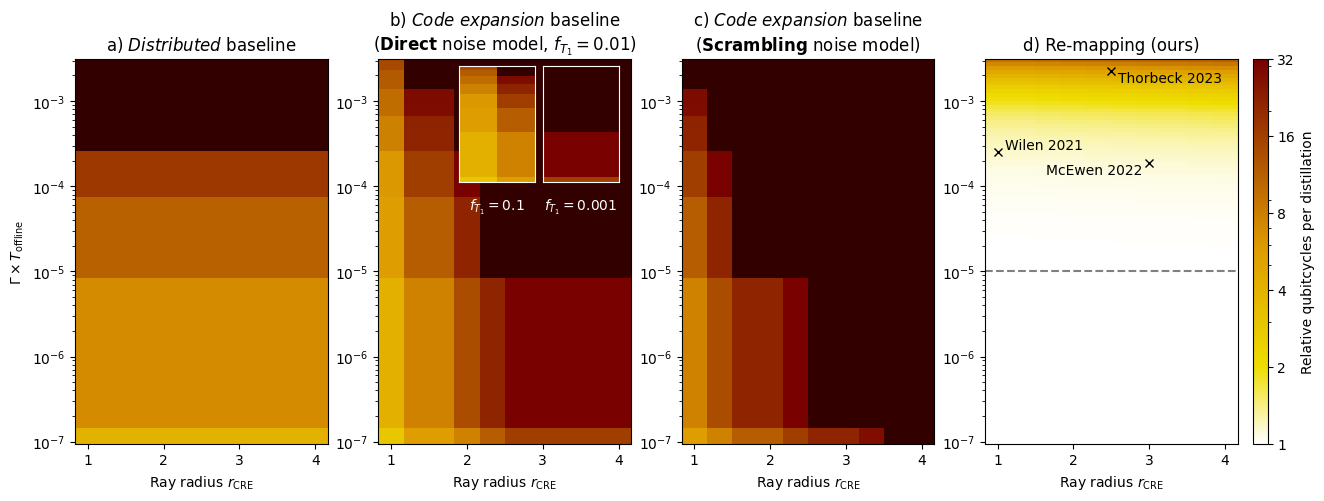

In [112]:
fig, ax = plt.subplots(1,4, figsize=(15, 5))

x, y = np.meshgrid(radii/2, rates, indexing='ij')

norm = mpl.colors.LogNorm(vmin=1, vmax=32)

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'mycmap', 
    [
        (0, '#FFFFFF'),
        (norm(2), '#EEDD00'),
        (norm(6), '#DD9900'),
        (1, '#770000'),
    ]                                                    
)
cmap.set_over('#330000')
cmap.set_under('white')
cmap.set_bad('#330000')

ax[0].pcolormesh(x, y, net_overheads_distributed, norm=norm, cmap=cmap)
ax[0].set_title(r'a) $\it{Distributed}$ baseline')
ax[0].set_ylabel(r'$\Gamma \times T_{\text{offline}}$')

ax[1].pcolormesh(x, y, net_overheads_expansion_direct[:,:,1], norm=norm, cmap=cmap)
ax[1].set_title(r'b) $\it{Code}$ $\it{expansion}$ baseline' + '\n' + r'($\bf{Direct}$ noise model, $f_{T_1} = 0.01$)')

with plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'white', 'ytick.color':'white', 'figure.facecolor':'black'}):
    ax_inset_1 = ax[1].inset_axes([0.32,0.68,0.3,0.3])
    ax_inset_1.pcolormesh(x, y, net_overheads_expansion_direct[:,:,0], norm=norm, cmap=cmap)
    ax_inset_1.set_yscale('log')
    ax_inset_1.tick_params(top=False, left=False, right=False, bottom=False, which='both')
    ax_inset_1.set_yticklabels([])
    ax_inset_1.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
    ax_inset_1.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax_inset_1.set_xlabel(r'$f_{T_1} = 0.1$', fontsize=10, color='white')

    ax_inset_2 = ax[1].inset_axes([0.65,0.68,0.3,0.3])
    ax_inset_2.pcolormesh(x, y, net_overheads_expansion_direct[:,:,2], norm=norm, cmap=cmap)
    ax_inset_2.set_yscale('log')
    ax_inset_2.tick_params(top=False, left=False, right=False, bottom=False, which='both')
    ax_inset_2.set_yticklabels([])
    ax_inset_2.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
    ax_inset_2.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax_inset_2.set_xlabel(r'$f_{T_1} = 0.001$', fontsize=10, color='white')

pcolormesh = ax[2].pcolormesh(x, y, net_overheads_expansion_scrambling, norm=norm, cmap=cmap)
ax[2].set_title(r'c) $\it{Code}$ $\it{expansion}$ baseline' + '\n' + r'($\bf{Scrambling}$ noise model)')

ax[3].pcolormesh(x, y, net_overheads_remap, norm=norm, cmap=cmap)
ax[3].set_title('d) Re-mapping (ours)')
ax[3].plot([3], [1/27/10*50e-3], 'x', color='k')
ax[3].annotate('McEwen 2022', (3, 1/27/10*50e-3), textcoords='offset points', xytext=(-5,-5), ha='right', va='center', color='k')
ax[3].plot([2.5], [1/27/16.4*1], 'x', color='k')
ax[3].annotate('Thorbeck 2023', (2.5, 1/27/16.4*1), textcoords='offset points', xytext=(5,-5), ha='left', va='center', color='k')
ax[3].plot([1], [1/4/50*50e-3], 'x', color='k')
ax[3].annotate('Wilen 2021', (1, 1/4/50*50e-3), textcoords='offset points', xytext=(5,5), ha='left', va='center', color='k')

ax[3].axhline(1e-5, color='gray', linestyle='--')

for i,axis in enumerate(ax):
    axis.set_yscale('log')
    # if i == 2:
    #     axis.set_xticks([])
    # else:
    axis.set_xlabel(r'Ray radius $r_{\text{CRE}}$')
    axis.set_xticks([1,2,3,4])

formatter = mpl.ticker.LogFormatter(2, labelOnlyBase=True) 
cbar = qc_utils.plot.add_cbar(ax[3], norm, cmap, size=0.01, format=formatter, ticks=[1,2,4,8,16,32], label='Relative qubitcycles per distillation')
# cbar = plt.colorbar(pcolormesh, ticks=[1, net_overheads_offline.max(), 4, 11,
# 17])
# cbar.set_ticks([1,2,4,8,16,32])

plt.savefig('../figures/ideal_detection_overheads.pdf', bbox_inches='tight')
plt.show()

In [115]:
def geo_mean(iterable):
    a = np.array(iterable).flatten()
    return a.prod()**(1.0/len(a))

best_baseline_direct = np.minimum(net_overheads_distributed, net_overheads_expansion_direct[:,:,0])
best_baseline_improvements_direct = (best_baseline_direct-1) / (net_overheads_remap-1)
best_baseline_improvements_direct = best_baseline_improvements_direct[np.isfinite(best_baseline_improvements_direct)]
best_baseline_scrambling = np.minimum(net_overheads_distributed, net_overheads_expansion_scrambling)
best_baseline_improvements_scrambling = (best_baseline_scrambling-1) / (net_overheads_remap-1)
best_baseline_improvements_scrambling = best_baseline_improvements_scrambling[np.isfinite(best_baseline_improvements_scrambling)]

print('Min improvement over best other method (direct):', best_baseline_improvements_direct.min())
print('Min improvement over best other method (scrambling):', best_baseline_improvements_scrambling.min())

print('Max improvement over best other method (direct):', best_baseline_improvements_direct.max())
print('Max improvement over best other method (scrambling):', best_baseline_improvements_scrambling.max())

print('Geomean improvement over best other method (direct):', geo_mean([mpmath.mpf(x) for x in best_baseline_improvements_direct]))
print('Geomean improvement over best other method (scrambling):', geo_mean([mpmath.mpf(x) for x in best_baseline_improvements_scrambling]))

best_baseline_qubitcycle_improvements_direct = best_baseline_direct / net_overheads_remap
best_baseline_qubitcycle_improvements_direct = best_baseline_qubitcycle_improvements_direct[np.isfinite(best_baseline_qubitcycle_improvements_direct)]
best_baseline_qubitcycle_improvements_scrambling = best_baseline_scrambling / net_overheads_remap
best_baseline_qubitcycle_improvements_scrambling = best_baseline_qubitcycle_improvements_scrambling[np.isfinite(best_baseline_qubitcycle_improvements_scrambling)]

print('Min qubitcycle improvement over best other method (direct):', best_baseline_qubitcycle_improvements_direct.min())
print('Min qubitcycle improvement over best other method (scrambling):', best_baseline_qubitcycle_improvements_scrambling.min())

print('Max qubitcycle improvement over best other method (direct):', best_baseline_qubitcycle_improvements_direct.max())
print('Max qubitcycle improvement over best other method (scrambling):', best_baseline_qubitcycle_improvements_scrambling.max())

print('Geomean qubitcycle improvement over best other method (direct):', geo_mean([mpmath.mpf(x) for x in best_baseline_qubitcycle_improvements_direct]))
print('Geomean qubitcycle improvement over best other method (scrambling):', geo_mean([mpmath.mpf(x) for x in best_baseline_qubitcycle_improvements_scrambling]))

# Overheads for each baseline point
print('Overheads for each baseline point:')
mcewen_rate = 1/27/10*50e-3
mcewen_radius = 3
mcewen_overhead_remap = net_overheads_remap[np.argmin(np.abs(radii-mcewen_radius)), np.argmin(np.abs(rates-mcewen_rate))]
mcewen_overhead_baseline = min(net_overheads_distributed[np.argmin(np.abs(radii-mcewen_radius)), np.argmin(np.abs(rates-mcewen_rate))], net_overheads_expansion_direct[np.argmin(np.abs(radii-mcewen_radius)), np.argmin(np.abs(rates-mcewen_rate)), 1])
mcewen_overhead_improvement = (mcewen_overhead_baseline-1) / (mcewen_overhead_remap-1)
mcewen_qubitcycle_improvement = mcewen_overhead_baseline / mcewen_overhead_remap
print('McEwen 2022:', mcewen_overhead_remap, mcewen_overhead_baseline, mcewen_overhead_improvement, mcewen_qubitcycle_improvement)

thorbeck_rate = 1/27/16.4*1
thorbeck_radius = 2.5
thorbeck_overhead_remap = net_overheads_remap[np.argmin(np.abs(radii-thorbeck_radius)), np.argmin(np.abs(rates-thorbeck_rate))]
thorbeck_overhead_baseline = min(net_overheads_distributed[np.argmin(np.abs(radii-thorbeck_radius)), np.argmin(np.abs(rates-thorbeck_rate))], net_overheads_expansion_direct[np.argmin(np.abs(radii-thorbeck_radius)), np.argmin(np.abs(rates-thorbeck_rate)), 1])
thorbeck_overhead_improvement = (thorbeck_overhead_baseline-1) / (thorbeck_overhead_remap-1)
thorbeck_qubitcycle_improvement = thorbeck_overhead_baseline / thorbeck_overhead_remap
print('Thorbeck 2023:', thorbeck_overhead_remap, thorbeck_overhead_baseline, thorbeck_overhead_improvement, thorbeck_qubitcycle_improvement)

wilen_rate = 1/4/50*50e-3
wilen_radius = 1
wilen_overhead_remap = net_overheads_remap[np.argmin(np.abs(radii-wilen_radius)), np.argmin(np.abs(rates-wilen_rate))]
wilen_overhead_baseline = min(net_overheads_distributed[np.argmin(np.abs(radii-wilen_radius)), np.argmin(np.abs(rates-wilen_rate))], net_overheads_expansion_direct[np.argmin(np.abs(radii-wilen_radius)), np.argmin(np.abs(rates-wilen_rate)), 1])
wilen_overhead_improvement = (wilen_overhead_baseline-1) / (wilen_overhead_remap-1)
wilen_qubitcycle_improvement = wilen_overhead_baseline / wilen_overhead_remap
print('Wilen 2021:', wilen_overhead_remap, wilen_overhead_baseline, wilen_overhead_improvement, wilen_qubitcycle_improvement)

for strength_idx in range(len(strengths)):
    best_baseline_direct = np.minimum(net_overheads_distributed, net_overheads_expansion_direct[:,:,strength_idx])
    best_baseline_qubitcycle_improvements_direct = best_baseline_direct / net_overheads_remap
    best_baseline_qubitcycle_improvements_direct = best_baseline_qubitcycle_improvements_direct[np.isfinite(best_baseline_qubitcycle_improvements_direct)]
    print(f'Strength = {strengths[strength_idx]}')
    print('Min qubitcycle improvement over best other method (direct):', best_baseline_qubitcycle_improvements_direct.min())
    print('Max qubitcycle improvement over best other method (direct):', best_baseline_qubitcycle_improvements_direct.max())
    print('Geomean qubitcycle improvement over best other method (direct):', geo_mean([mpmath.mpf(x) for x in best_baseline_qubitcycle_improvements_direct]))
    

Min improvement over best other method (direct): 1.5041538510442913
Min improvement over best other method (scrambling): 5.276563945319776
Max improvement over best other method (direct): 64748.26535321197
Max improvement over best other method (scrambling): 75641.08541172852
Geomean improvement over best other method (direct): 567.84592688658451897839061866584562446000819902735
Geomean improvement over best other method (scrambling): 1277.894584928266553057567417532182555620347063125
Min qubitcycle improvement over best other method (direct): 1.4533133730910819
Min qubitcycle improvement over best other method (scrambling): 3.999625816644771
Max qubitcycle improvement over best other method (direct): 18.093520929341032
Max qubitcycle improvement over best other method (scrambling): 205.56900168079386
Geomean qubitcycle improvement over best other method (direct): 6.5046736213226018688590222763603271823617061330734
Geomean qubitcycle improvement over best other method (scrambling): 13.